In [1]:
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import ertools as er

import matrixtools as mt
import regiontools as rt
import timeseriestools as ts


# Conduction Canonical Correlation Analysis (CCA) to compare Sea Surface Temperatures and land Surface Temperatures

In [ ]:
def makeTS(ds,var):
    X = ds[var].values
    lon = ds.lon.values
    lat = ds.lat.values
    
    val = np.logical_not(np.isnan(X[0,:,:]))

    area = np.outer(np.cos(np.pi*lat/180), np.ones(len(lon)))
    x = X[:,val]
    area = area[val]

    x = np.dot(x,area)/np.sum(area)

    return x

### Reading out a the surface temperature and SST

In [ ]:
ds = xr.open_dataset('Data/CPC/SurfTemp/air.mon.mean.nc').sel(time=slice('1/1/1979','6/1/2021'))
globe_air = makeTS(ds,'air')

air = ds.air.values
lon_air = ds.lon.values
lat_air = ds.lat.values

sst = er.all_sstInRegion(1979,2021,[0,360],[-90,90])
globe_sst = er.erTimeSeries(1979,2021,lonBounds=[0,360],latBounds=[-90,90])
lon_sst,lat_sst = er.readLonLat()





In [ ]:
air,lat_air,lon_air = rt.adjustAllRes(air,lat_air,lon_air,180,360)

globe_sst = ts.removeCycle(globe_sst)
globe_air = ts.removeCycle(globe_air)
air = rt.removeGridCycle(air)
sst = rt.removeGridCycle(sst)
air = rt.detrendRegion(air,1,False)
sst = rt.detrendRegion(sst,1,False)


air = air - np.mean(air,axis=0)
sst = sst - np.mean(sst,axis=0)

### Calculating CCA for the given data set

In [ ]:
cca = mt.cca(sst,air,lon_sst,lat_sst,lon_air,lat_air)

### Getting loading vectors

In [ ]:
n = 0

p_sst = cca['Px'][n,:,:]
p_air = cca['Py'][n,:,:]

p_list = [p_sst,p_air]
lon_list = [lon_sst,lon_air]
lat_list = [lat_sst,lat_air]

title_list = ['SST','SurfTemp']


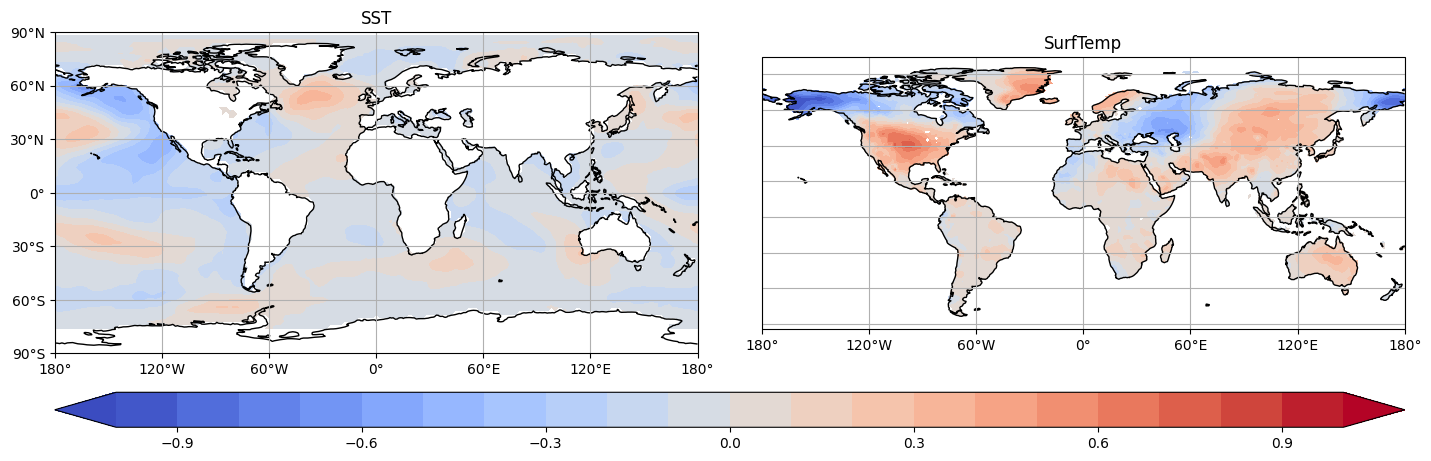

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,7),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.flatten()
clevs = np.arange(-1.,1.1,.1)

for i,ax in enumerate(axs):
    p = p_list[i]
    lon = lon_list[i]
    lat = lat_list[i]
    title = title_list[i]

    p,lon = add_cyclic_point(p,coord=lon)

    cs = ax.contourf(lon,lat,p,cmap='coolwarm',levels=clevs,extend='both',transform=ccrs.PlateCarree())

    #plt.colorbar(cs,orientation='horizontal',pad = 0.05)
    ax.coastlines()
    ax.gridlines()
    ax.set_title(title)

    ax.set_xticks(np.arange(-180,181,60))
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    if(i==0):
        ax.set_yticks(np.arange(-90,91,30))
        lat_formatter = cticker.LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

fig.subplots_adjust(bottom=0.07,top=0.9,left=0.05,right=0.95,wspace=0.1,hspace=0.1)
cbar_ax = fig.add_axes([0.05,0.15,0.9,0.05])
cbar=fig.colorbar(cs,cax=cbar_ax,orientation='horizontal')#,label='RMS/RMS_clim')

plt.show()


### Getting and plotting the variates

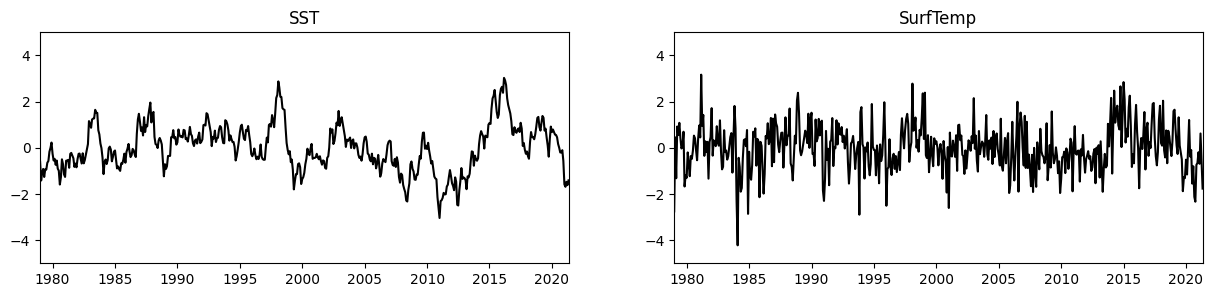

In [ ]:
r_sst = cca['Rx'][:,n]
r_air = cca['Ry'][:,n]

r_list = [r_sst,r_air]

time = ds.time.values

fig,axs = plt.subplots(nrows =1,ncols=2,figsize=(15,3))
axs = axs.flatten()

for i,ax in enumerate(axs):
    r = r_list[i]
    title = title_list[i]

    ax.plot(time,r,'k')
    ax.axis([min(time),max(time),-5,5])

    ax.set_title(title)

plt.show()

In [ ]:
corr = cca['rho']
print(corr[n])

0.9001899636274809
